In [63]:
%matplotlib inline

### Installing and importing modules

In [64]:
import sys
import os

!{sys.executable} -m pip install advertools
!{sys.executable} -m pip install textblob

In [65]:
# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for data transformation
import pandas as pd 
import numpy as np
from datetime import datetime
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# for model instantion & tuning
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

now = datetime.now()

date_time = now.strftime("%m%d%y-%H%M")

In [66]:
# https://www.nltk.org/
# import the Natural Language Toolkit (nltk) library to further process the parsed word data
import nltk
import advertools as adv
from nltk.corpus import stopwords
from textblob import TextBlob, Word
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Importing the dataset

In [67]:
combined_df = pd.read_csv('/content/drive/MyDrive/Project Capstone/combined_reviews.csv')

combined_df['review'] = combined_df['review'].astype(str)
# convert 'date' column to datetime since dtypes aren't preserved in csv files
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112264 entries, 0 to 112263
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    112264 non-null  datetime64[ns]
 1   review  112264 non-null  object        
 2   rating  112264 non-null  int64         
 3   type    112264 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 3.4+ MB


Initial data exploration

For the initial data exploration, we compared the frequency of reviews over a time series.

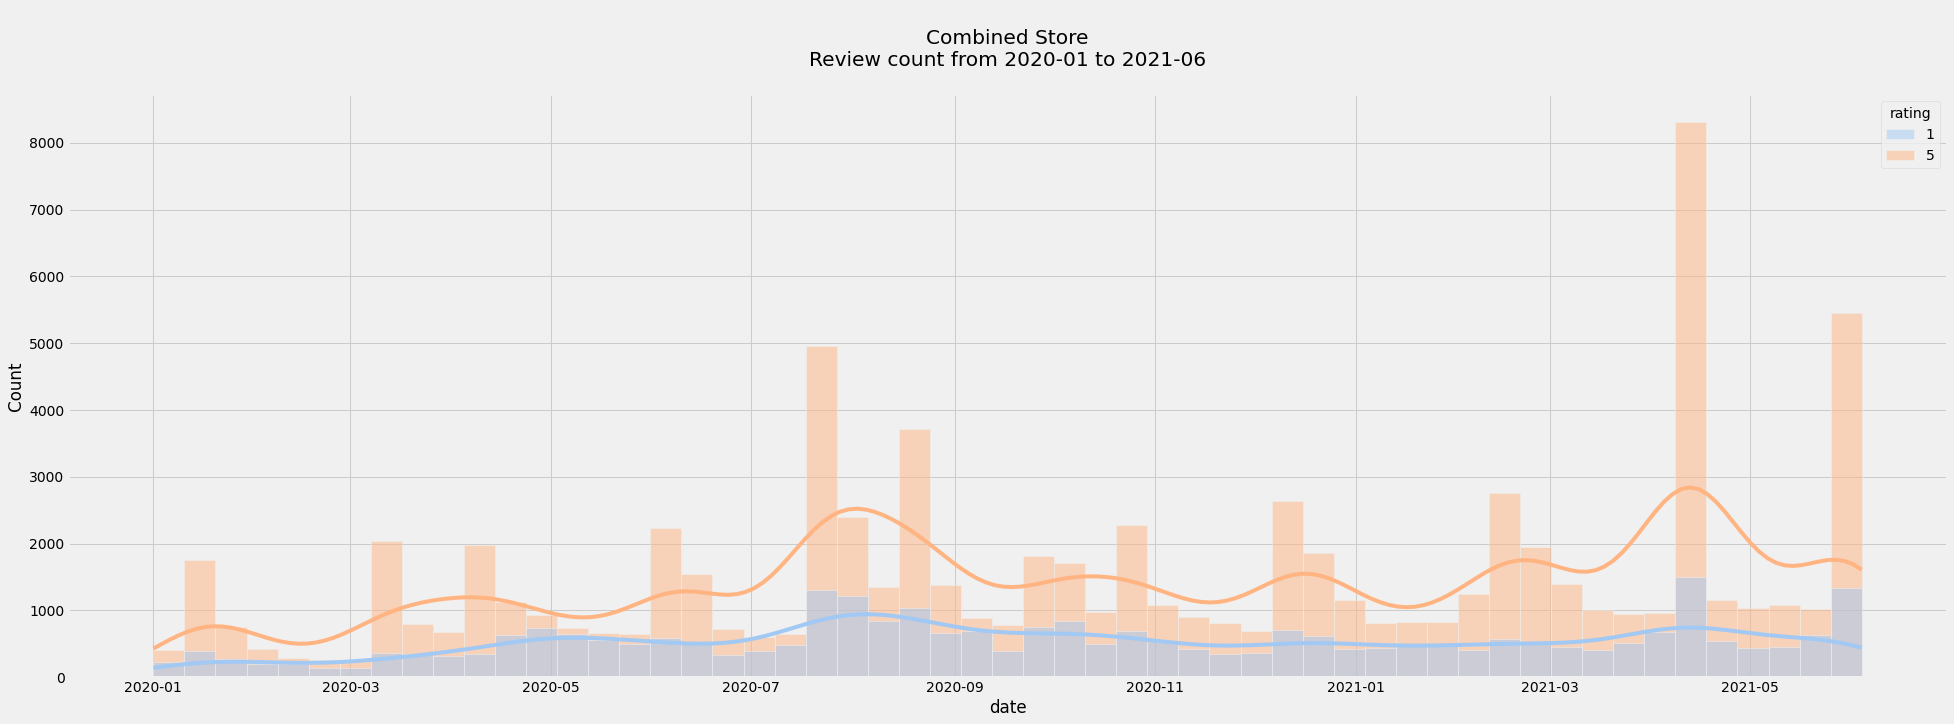

In [70]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(30, 10))

as_plot = sns.histplot(ax=ax, data=combined_df, x='date', hue='rating', palette='pastel', kde=True)
as_plot.title.set_text('\nCombined Store\nReview count from 2020-01 to 2021-06\n')

### Preprocessing the data for the LSTM Model

#### Splitting the dataset

In [72]:
df_train, df_test = train_test_split(combined_df, test_size=0.01, random_state=42)

#### Remove punctuation from all reviews

In [73]:
import string

# init empty list
clean_lst = []

for review in combined_df['review']:
# for review in gps_df['content']:
    # convert each review to a string to avoid AttributeErrors while using the translate method
    str_review = str(review)
    clean_review = str_review.translate(str.maketrans('', '', string.punctuation))
    clean_lst.append(clean_review)

#### Remove emojis/emoticons, flags (iOS), pictographs, and transportation and map symbols from all reviews

In [74]:
# init empty list
final_lst = []

for review in clean_lst:
    final_review = review.encode('ascii', 'ignore').decode('ascii')
    final_lst.append(final_review.lower().strip())
    
# set all strings to lowercase and split every line to strings
review_lst = [line.split() for line in final_lst]

#### Removing stopwords and lemmatizing each word using the nltk library

In [119]:
import re
import nltk
import spacy 
import advertools as adv
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import wordnet, words, stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# index value
value = 29

# concatenate english and tagalog stopwords into one list
stop_words = stopwords.words('english') + list(adv.stopwords['tagalog']) + \
            ['gcash', 'could', 'doe', 'might', 'must', 'need', 'sha', \
             'would', 'far', 'nag', 'already', 'always', 'app', 'cant', \
             'dont', 'even', 'get', 'please', 'say', 'still', 'try', 'use', \
             'yung', 'day', 'keep', 'lang', 'like', 'make', 'nyo', 'the', 'to', \
             'ive', 'naman', 'one', 'take', 'fully', 'also', 'app..', \
             'give', 'much', 'okay', 'pag', 'sana', 'star', 'sya', 'thank', \
             'usefull', 'verry', 'wala', 'want', 'way', 'well', 'wow', 'didnt', \
             'every', 'guy', 'hope', 'kayo', 'know', 'let', 'link', 'mag', 'many', \
             'message', 'never', 'nothing', 'open', 'put', 'really', 'seem', 'start', \
             'thing', 'whenever', 'wont', 'wrong', 'yet', 'almost', 'anymore', 'back', \
             'come', 'doesnt', 'especially', 'everytime', 'first', 'globe', 'last', \
             'month', 'new', 'niyo', 'since', 'something', 'think', 'thru', 'ung', \
             'without', 'suppose', 'tapos', 'another', 'anything', 'u', 'thats', \
             'via', 'etc', 'everything', 'everywhere', 'io', 'life', \
             'list', 'lot', 'maybe', 'meter', 'next' , 'past', 'phone', 'pls', \
             'plus', 'point', 'pwede', 'see', 'show', 'sometimes', 'team', 'whats', \
             'wish', 'year', 'gamitin', 'girl', 'hand', 'happen', 'hello', 'high', \
             'however', 'hurt', 'though', 'true', 'usually', 'screen', 'soon', 'acc', \
             'add', 'yun', 'yes', 'youre', 'coz', 'acct', 'agad', 'line', 'long', 'today', \
             'go', 'abd', 'kna', 'luv', 'kna', 'god', 'wlang', 'yeah', 'id', 'idk', 'iam', \
            'ill', 'ina', 'padin', 'kahit', 'pede', 'nang', 'supper', 'khit', 'kahit'] + \
            ['to', 'the', 'it', 'they', 'and', 'you', 'cant', 'of', 'its', 'for', 'is', 'na', 'for', 'so']

# Helper function to lemmatize with part of speech (POS) tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

token_pattern = re.compile(r"(?u)\b\w\w+\b")

# Remove stop words from each line and lemmatize each word
print("\n Lemmatizing, please wait a few minutes...")
clean_review_lst = [[lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words if not word in stop_words and len(word) >= 3 and re.match("[a-z].*", word) and re.match(token_pattern, word)] for words in review_lst]

# compare original output from 'cleaned' output 
print(f'\nOriginal (length = {len(combined_df.iloc[value, 1].split())}):\n{combined_df.iloc[value, 1].split()}')
print(f'\nPreprocessed (length = {len(clean_review_lst[value])}):\n{clean_review_lst[value]}\n')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [76]:
print(f'\nOriginal (length = {len(combined_df.iloc[value, 1].split())}):\n{combined_df.iloc[3090, 1].split()}')
print(f'\nPreprocessed (length = {len(clean_review_lst[value])}):\n{clean_review_lst[3090]}\n')


Original (length = 2):
['Its', 'a', 'big', 'help', 'for', 'me..love', 'it!']

Preprocessed (length = 1):
['big', 'help', 'melove']



In [77]:
# initialize the Tokenizer with the oov_token parameter to specify each out of vocab word with a special vocabulary token; <OOV>.
# will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence/texts_to_sequences calls
tokenizer = Tokenizer(oov_token='<OOV>')

# create tokens for every word in the review corpus
tokenizer.fit_on_texts(clean_review_lst)
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(clean_review_lst)
padded_data = pad_sequences(sequences, padding='post')

# print(f'Word index:\n{tokenizer.word_index}')

# print(f'\nOriginal:\n{as_df.iloc[17, 1]}')
print(f'\nOriginal sentence:\n{combined_df.iloc[value, 1]}')
print(f'\nPreprocessed sentence:\n{clean_review_lst[value]}')
print(f'\nTokenized sentence:\n{sequences[value]}')
print(f'\nPadded tokenized sentence:\n{padded_data[value]}')
print(f'\nShape of tokenized review corpus:\n{padded_data.shape}')


Original sentence:
Very helpful

Preprocessed sentence:
['helpful']

Tokenized sentence:
[26]

Padded tokenized sentence:
[26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

Shape of tokenized review corpus:
(112264, 165)


### Train-test split

### Instantiating the model

Recurrent neural networks

A Long Short Term Memory network is a kind of recurrent neural network. A recurrent neural network is a neural network that attempts to model time or sequence dependent behaviour – such as language, stock prices, electricity demand and so on. This is performed by feeding back the output of a neural network layer at time t to the input of the same network layer at time t + 1. It looks like this:

![rnn diagram](https://adventuresinmachinelearning.com/wp-content/uploads/2017/09/Explicit-RNN.jpg)

Recurrent LSTM tutorial - RNN diagram with nodes
Recurrent neural network diagram with nodes shown

Recurrent neural networks are “unrolled” programmatically during training and prediction, so we get something like the following:

![rnn diagram2](https://adventuresinmachinelearning.com/wp-content/uploads/2017/09/Recurrent-neural-network-768x251.png)

In [78]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

# Use a Sequential model to stack layers
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,  return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['binary_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          861344    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 32)          6272      
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16)                2624      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
dropout_8 (Dropout)          (None, 4)                

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [79]:
from keras.callbacks import ModelCheckpoint

model_path = '/content/drive/MyDrive/Project Capstone/2_lstm_model_'+ date_time +'.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [checkpoint]

In [80]:
# convert "rating" column into an array format as input for the model
sentiment_label = combined_df.rating.factorize()
sentiment_label[0]

array([0, 1, 0, ..., 0, 1, 1])

In [81]:
num_epochs = 17

# use validation_split param to split data into training and validation datasets
history = model.fit(
    padded_data,
    sentiment_label[0],
    validation_split=0.8, 
    epochs=num_epochs,
    callbacks=callbacks
)

Epoch 1/17
702/702 [==============================] - 219s 303ms/step - loss: 0.6001 - binary_accuracy: 0.7249 - val_loss: 0.4863 - val_binary_accuracy: 0.7269

Epoch 00001: val_binary_accuracy improved from -inf to 0.72690, saving model to /content/drive/MyDrive/Project Capstone/2_lstm_model_070221-0551.h5
Epoch 2/17
702/702 [==============================] - 210s 300ms/step - loss: 0.4675 - binary_accuracy: 0.7875 - val_loss: 0.3290 - val_binary_accuracy: 0.9093

Epoch 00002: val_binary_accuracy improved from 0.72690 to 0.90930, saving model to /content/drive/MyDrive/Project Capstone/2_lstm_model_070221-0551.h5
Epoch 3/17
702/702 [==============================] - 210s 299ms/step - loss: 0.4039 - binary_accuracy: 0.8179 - val_loss: 0.2914 - val_binary_accuracy: 0.9168

Epoch 00003: val_binary_accuracy improved from 0.90930 to 0.91678, saving model to /content/drive/MyDrive/Project Capstone/2_lstm_model_070221-0551.h5
Epoch 4/17
702/702 [==============================] - 210s 300ms/st

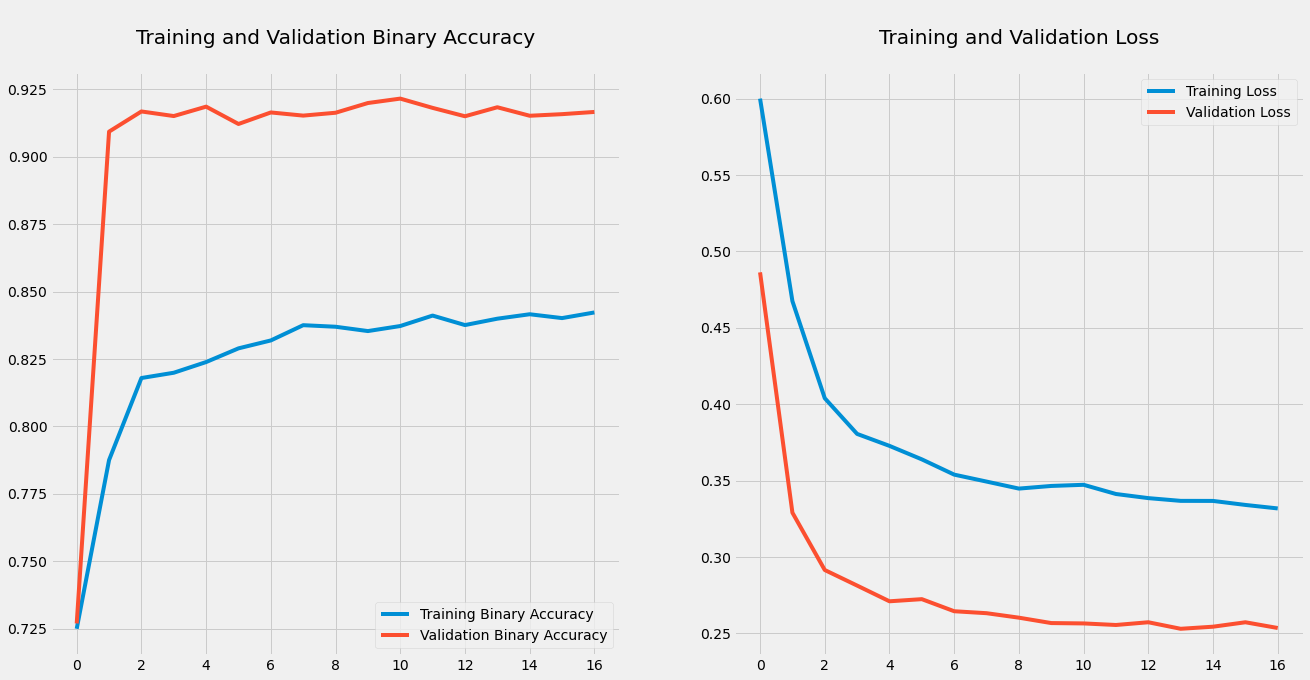

In [82]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Binary Accuracy')
plt.plot(val_acc, label='Validation Binary Accuracy')
plt.legend(loc='lower right')
plt.title('\nTraining and Validation Binary Accuracy\n')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('\nTraining and Validation Loss\n')
plt.show()

### Testing the model

In [99]:
# sample_text = "This app is amazing! I loved using it"
sample_text = "This is a bad app. This is an evil app."

# preprocess input
word_lst = sample_text.encode('ascii', 'ignore').decode('ascii').translate(str.maketrans('', '', string.punctuation)).lower().split()
clean_word_lst = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_lst if not word in stop_words]

# tokenize and pad
sequences = tokenizer.texts_to_sequences(clean_word_lst)
padded_data = pad_sequences(sequences, padding='post')

# If the probability is >= 0.5, it is negative else it is positive (based on sentiment_label)
probability = model.predict(np.array([padded_data]))
prediction = 'negative' if probability >= 0.5 else 'positive'

print(f'Sentiment label:\n{sentiment_label}')
print(f'\nReview:\n{sample_text}')
print(f'\nWord list:\n{word_lst}')
print(f'\nPreprocessed:\n{clean_word_lst}')
print(f'\nTokenized review:\n{sequences}')
print(f'\nRaw probability:\n{probability}')
print(f'\nPredicted sentiment:\n{prediction}')

Sentiment label:
(array([0, 1, 0, ..., 0, 1, 1]), Int64Index([1, 5], dtype='int64'))

Review:
This is a bad app. This is an evil app.

Word list:
['this', 'is', 'a', 'bad', 'app', 'this', 'is', 'an', 'evil', 'app']

Preprocessed:
['bad', 'evil']

Tokenized review:
[[47], [1]]

Raw probability:
[[0.50026006]]

Predicted sentiment:
negative


### Testing the model against test data

#### Cleaning Test Data

In [178]:
# synthesized cleaning process into three different functions
def clean(review):
  final_review = review.encode('ascii', 'ignore').decode('ascii')
  word_lst = final_review.translate(str.maketrans('', '', string.punctuation)).lower()
  return word_lst

def get_number_of_elements(review):
    count = 0
    for element in review:
        count += 1
    return count

def split(review):
    word_lst = review.split()
    clean_word_lst = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_lst if not word in stop_words]
    return clean_word_lst

def reclean(review):
  a = ""
  for word in review.split():
    if word not in stop_words:
      a += word+" "
  return a

In [179]:
# Create a copy of the test data
df_copy = df_test.copy()

In [ ]:
# Clean the test dataframe
print(df_copy.shape)

df_copy['cleaned'] = df_copy['review'].apply(lambda x: clean(x))
df_copy['splitted'] = df_copy['cleaned'].apply(lambda x: split(x))
df_copy['recleaned'] = df_copy['cleaned'].apply(lambda x: reclean(x))
df_copy['recleaned'] = df_copy['recleaned'].astype(str)
df_copy['len'] = df_copy['splitted'].apply(lambda x: get_number_of_elements(x))

df_copy.splitted = df_copy.splitted.replace('\s+', '', regex=True)
nan_value = float("NaN")
df_copy.replace("", nan_value, inplace=True)
df_copy = df_copy.loc[df_copy['len'] > 0]
print(df_copy.shape)

#### Getting predicted sentiment value from the model 

In [87]:
def senti(clean_word_lst):
    # try:
      # tokenize and pad
      sequences = tokenizer.texts_to_sequences(clean_word_lst)
      padded_data = pad_sequences(sequences, padding='post')

      # If the probability is >= 0.5, it is negative else it is positive (based on sentiment_label)
      polarity = model.predict(np.array([padded_data]))
      prediction = '1' if probability >= 0.5 else '5'

      return float(polarity)
    # except:
        # print("An exception occurred. Could not tokenize: " + clean_word_lst)


        
df_copy['polarity'] = df_copy['splitted'].apply(lambda x: senti(x))
df_copy.head()

,date,review,rating,type,cleaned,splitted,len,pred
29127,2020-09-13 13:14:13,nice but ano nangyare na gcash nagpaload ako 9...,5,play store,nice but ano nangyare na gcash nagpaload ako 9...,"[nice, nangyare, nagpaload, 90, nagbawas, nmn,...",10,0.470208
101089,2021-01-28 04:25:06,Useless app ever,1,play store,useless app ever,"[useless, ever]",2,0.462234
67377,2020-03-15 09:16:21,Good,5,play store,good,[good],1,0.584918
91017,2020-11-30 16:21:34,I have many experiences of Gcash that when it ...,1,play store,i have many experiences of gcash that when it ...,"[experience, 12, buy, load, balance, time, lim...",16,0.511782
70950,2020-09-29 01:24:02,Very usefull now a days,5,play store,very usefull now a days,[day],1,0.530169


Convert polarity into ratings

In [88]:
def pred(rate):
    if rate > 0.5:
        prediction = 5
        return prediction
    else: 
        prediction = 1
        return prediction

df_copy['senti'] = df_copy['polarity'].apply(lambda x: pred(x))
df_copy.head()

,date,review,rating,type,cleaned,splitted,len,pred,senti
29127,2020-09-13 13:14:13,nice but ano nangyare na gcash nagpaload ako 9...,5,play store,nice but ano nangyare na gcash nagpaload ako 9...,"[nice, nangyare, nagpaload, 90, nagbawas, nmn,...",10,0.470208,1
101089,2021-01-28 04:25:06,Useless app ever,1,play store,useless app ever,"[useless, ever]",2,0.462234,1
67377,2020-03-15 09:16:21,Good,5,play store,good,[good],1,0.584918,5
91017,2020-11-30 16:21:34,I have many experiences of Gcash that when it ...,1,play store,i have many experiences of gcash that when it ...,"[experience, 12, buy, load, balance, time, lim...",16,0.511782,5
70950,2020-09-29 01:24:02,Very usefull now a days,5,play store,very usefull now a days,[day],1,0.530169,5


In [89]:
df_copy.to_csv('/content/drive/MyDrive/Project Capstone/2_predict_'+ date_time +'.csv')

### Visualizations

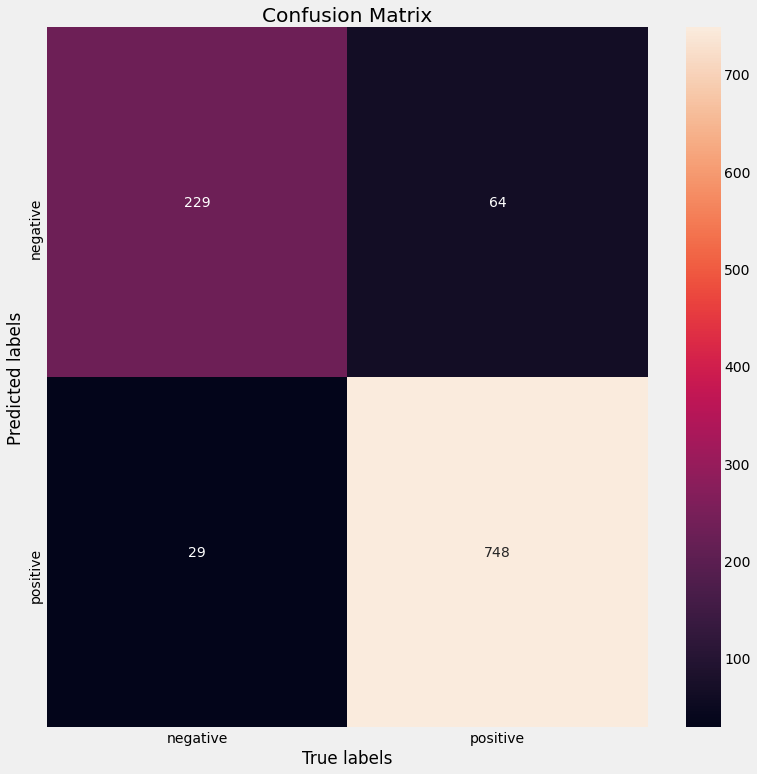

In [90]:
# %%time
from sklearn.metrics import confusion_matrix
import operator

testdf = df_copy.copy()

cm = confusion_matrix(testdf['rating'].to_numpy(), testdf['senti'].to_numpy())
plt.figure(figsize=(12,12))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'positive']); ax.yaxis.set_ticklabels(['negative', 'positive']);

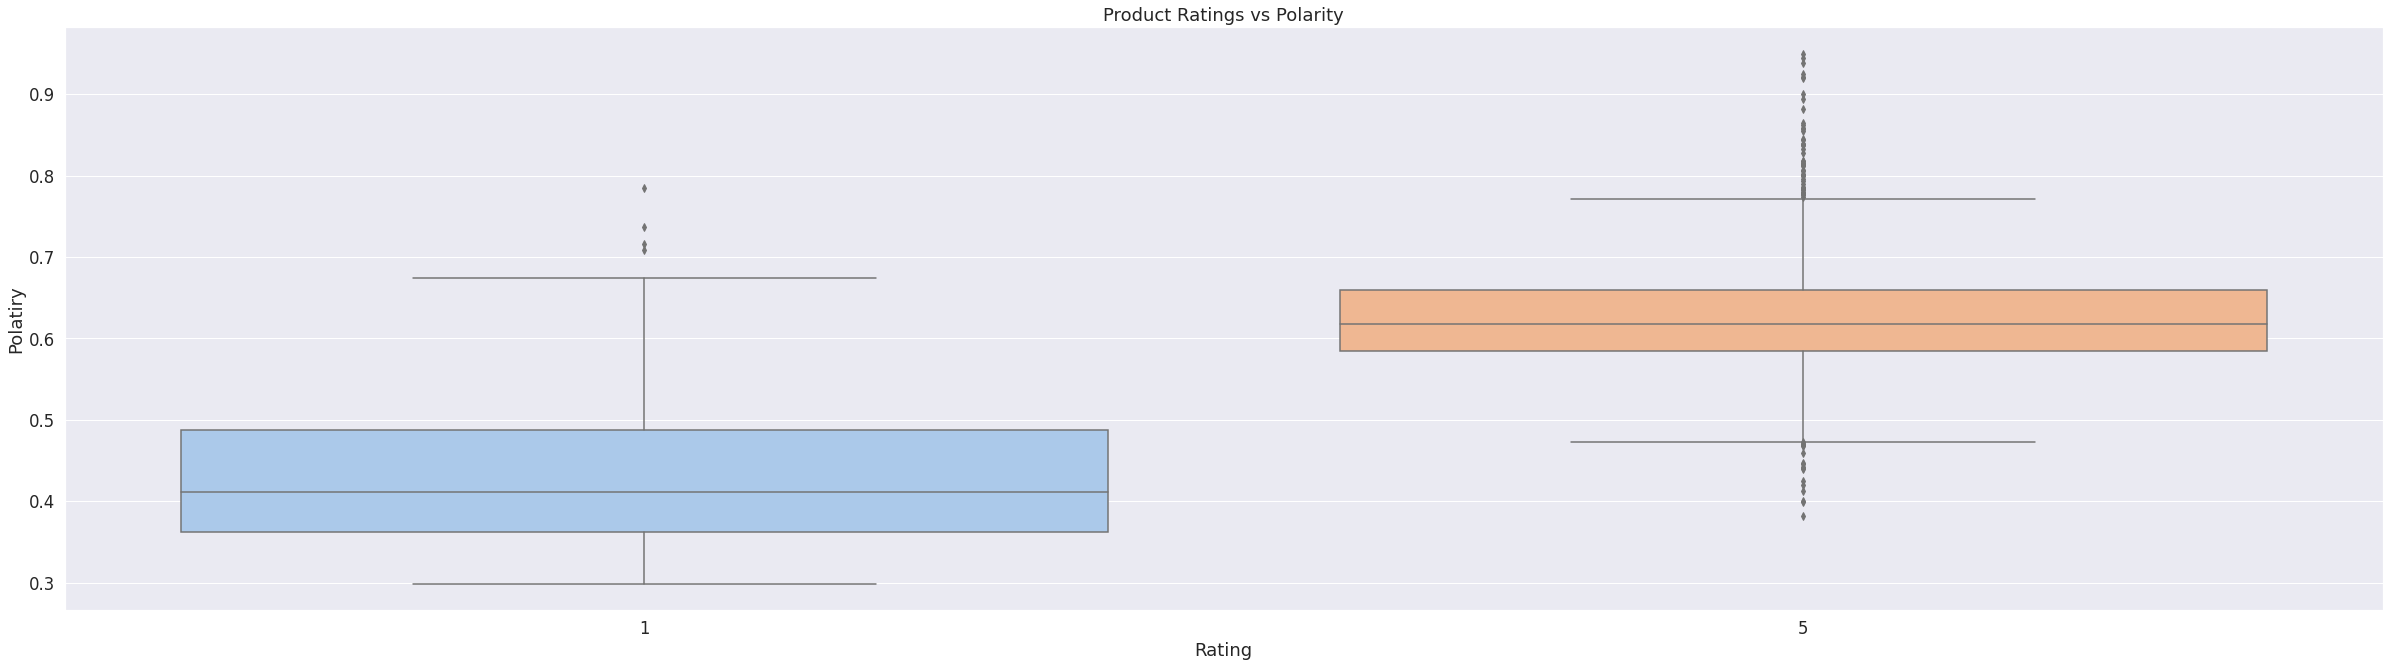

In [103]:
import seaborn as sns

testdf.sort_values('rating')
plt.figure(figsize = (37, 10))
sns.boxplot(x = 'rating', y = 'pred', data = testdf, palette="pastel")
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
plt.xlabel("Rating")
plt.ylabel("Polatiry")
plt.title("Product Ratings vs Polarity")
plt.show()

In [182]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec=CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

df_n = df_copy.loc[(df_copy['rating'] == 1)]
df_n = df_n[df_n['recleaned'].notna()]
common_words = get_top_n_words(df_n['recleaned'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', "Count"])


,Review,Count
0,update,47
1,account,39
2,money,38
3,using,29
4,load,28
5,time,26
6,service,25
7,fix,25
8,cash,23
9,bank,19


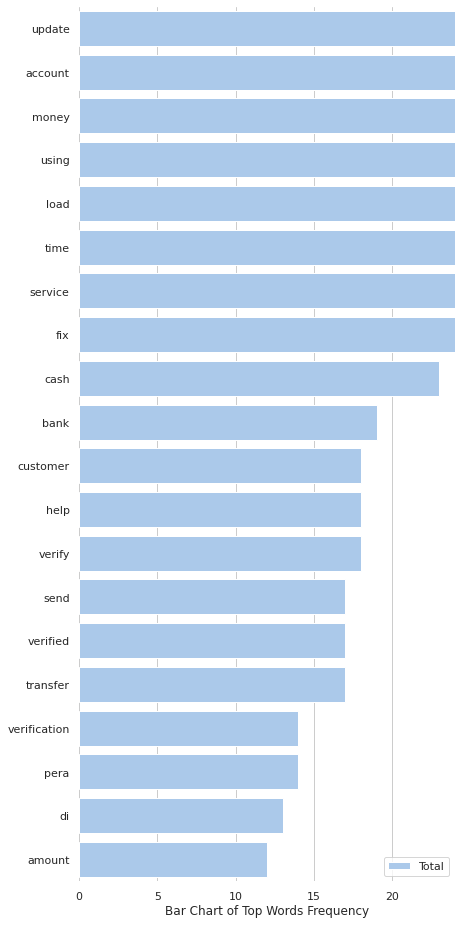

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="Count", y="Review", data=df1,
            label="Total", color="b")

# Add a legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Bar Chart of Top Words Frequency")
sns.despine(left=True, bottom=True)

In [ ]:
## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from sklearn.manifold import TSNE

## Get weights
conv_embds = model.layers[0].get_weights()[0]
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= clean_word_lst[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)
## Visualize words in two dimensions 
conv_tsne_embds = TSNE(n_components=3).fit_transform(conv_embds)
plot_words(conv_tsne_embds, 0, 2000, 1)